*The file associated with the challenge is a collection of 100k tweets from different companies as well as people following those and providing comments and opinions about them. Your task is to determine the overall sentiment of these tweets, and present the results as you see fit to be the most informative way for a non-technical person.*

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# python import
import numpy as np
import pandas as pd
import re
import datetime as dt
import os

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# custom imports
from src.preprocessing import *

In [3]:
# inits, options
pd.set_option('display.max_colwidth', None)
sns.set_style("whitegrid")

In [4]:
# load data
# file_name = "100ktweets.csv"
file_name = '100ktweets.xlsx'
# df = pd.read_csv(f'data/{file_name}')
df = pd.read_excel(f'data/{file_name}')

In [5]:
df.shape

(100000, 14)

In [6]:
df.info()
# correct dtypes
# nans only in 'Location', 'Company_url' columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   ID                    100000 non-null  int64         
 1   Username              100000 non-null  object        
 2   Name                  100000 non-null  object        
 3   Datetime              100000 non-null  datetime64[ns]
 4   Tweet_Id              100000 non-null  int64         
 5   Text                  100000 non-null  object        
 6   Tweet_Retweet_count   100000 non-null  int64         
 7   Tweet_Favorite_count  100000 non-null  int64         
 8   Tweet_language        100000 non-null  object        
 9   Source                100000 non-null  object        
 10  Location              96005 non-null   object        
 11  Company_url           85825 non-null   object        
 12  User_followers_count  100000 non-null  int64         
 13  

In [7]:
# some of the tweets appears to be corrupted - here for example, the original tweet 
# (https://twitter.com/kaarmann/status/1328998738296246273) is a little bit longer.
df.loc[df.Tweet_Id == 1328998738296246272, 'Text']

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


0    RT @TransferWise: In case you don’t speak Bankese, we’ve translated it for you.\n\nBecause knowing how much it really costs to send money abr…
Name: Text, dtype: object

In [8]:
# the length of this tweet == 140 characters, which is the old character limit of a tweeter post.
df.loc[df.Tweet_Id == 1328998738296246272, 'Text'].str.len()

0    140
Name: Text, dtype: int64

### peek at the data

In [9]:
# lengths of the tweets
df_len = (df[['Text']].assign(length = lambda x: x['Text'].str.len())
                      .sort_values(by='length', ascending=False))
df_len['length'].describe()

count    100000.00000
mean        138.28988
std          67.27009
min           7.00000
25%          94.00000
50%         140.00000
75%         145.00000
max         947.00000
Name: length, dtype: float64

<AxesSubplot:xlabel='length', ylabel='Count'>

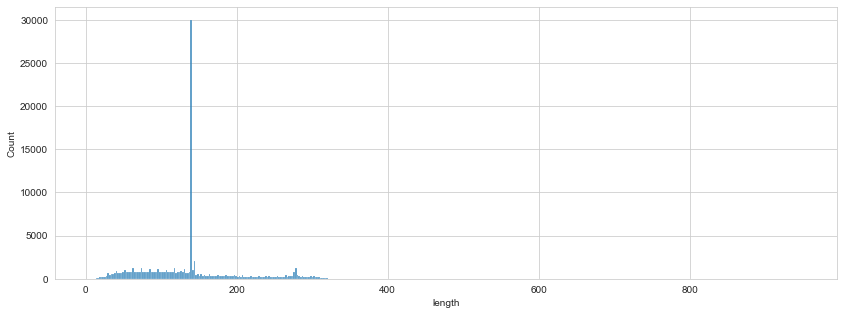

In [10]:
f, ax = plt.subplots(figsize=(14, 5))
sns.histplot(data=df_len, x="length")

In [11]:
# weird spike ? - 140 charcters
df_len['length'].mode()
# 140 is the Twitter's previous (before Sep 2017) character limit, but every tweet in the dataset was posted after this date
# it appears that a lot of tweets are corrupted in the same way: cut off after 140 characters
# I've checked the original file on the Google Drive and it's the case
# The only solution to that is to try to download the same tweets using Twitter API again

0    140
dtype: int64

In [12]:
# checking tweets above twitter's character limit
df_len.query("length > 280") 
# 4207 of tweets with higher tweeter length than allowed 
# @names that auto-populate at the start of a reply Tweet don't count towards the character limit
# there are more subtleties to investigate (exceptions) but they doesn't seem important from the point of view of a task

,Text,length
48767,@RoyPentland @HenryK_B_ @Willard1951 @DrSusanBarring1 @NoelTurner194 @yankeepirate247 @walther_jeff @ATomalty @EuphoricEuler @dan613 @saminhim @elqulime @DawnTJ90 @NikolovScience @jimdtweet @moaningbs @uk_ecology @AtomsksSanakan @BakkMatt @MexicoRS78 @PierreTherrie14 @brjma @RetributiaNorb @PeletteSean @EastWhately @Kenneth72712993 @HMS_Indomitable @PolitiPeriphery @GillesnFio @Michael46830937 @MedBennett @DaveOx13 @Eradinotte @PeterJrgen12 @jch_of @JSegor @Tony__Heller @d_e_mol @rln_nelson @Chrisdebois1 @MassiMassian @banurfeels @AngstromU @waitwha35825253 @dhaessel0 @RadioFreeTony @MonkeyMyBack @NeilSul70388398 @RushhourP @mtnman0038 The Red Kite (a raptor) was hunted almost to extinction in the UK. The Joint Nature Conservation Committee decided to reintroduce the species into England and Scotland. It is doing incredibly well (despite all those killer wind tribunes) ... why? Because no one is shooting them! https://t.co/1bcCdL1csR,947
48765,@GillesnFio @DrSusanBarring1 @ATomalty @HenryK_B_ @Willard1951 @NoelTurner194 @yankeepirate247 @walther_jeff @EuphoricEuler @dan613 @RoyPentland @saminhim @elqulime @DawnTJ90 @NikolovScience @jimdtweet @moaningbs @uk_ecology @AtomsksSanakan @BakkMatt @MexicoRS78 @PierreTherrie14 @brjma @RetributiaNorb @PeletteSean @EastWhately @Kenneth72712993 @HMS_Indomitable @PolitiPeriphery @Michael46830937 @MedBennett @DaveOx13 @Eradinotte @PeterJrgen12 @jch_of @JSegor @Tony__Heller @d_e_mol @rln_nelson @Chrisdebois1 @MassiMassian @banurfeels @AngstromU @waitwha35825253 @dhaessel0 @RadioFreeTony @MonkeyMyBack @NeilSul70388398 @RushhourP @mtnman0038 Classic climate change denial.\n\nThey say 'look how bad green solutions are' forgetting the millions that die due to fossil fuel created air pollution &amp; ground water contamination. The oil wars etc. And of course let's not forget #ClimateChange \n\nhttps://t.co/EikyPTZli4,917
48764,"@GillesnFio @ATomalty @HenryK_B_ @Willard1951 @DrSusanBarring1 @NoelTurner194 @yankeepirate247 @walther_jeff @EuphoricEuler @dan613 @RoyPentland @saminhim @elqulime @DawnTJ90 @NikolovScience @jimdtweet @moaningbs @uk_ecology @AtomsksSanakan @BakkMatt @MexicoRS78 @PierreTherrie14 @brjma @RetributiaNorb @PeletteSean @EastWhately @Kenneth72712993 @HMS_Indomitable @PolitiPeriphery @Michael46830937 @MedBennett @DaveOx13 @Eradinotte @PeterJrgen12 @jch_of @JSegor @Tony__Heller @d_e_mol @rln_nelson @Chrisdebois1 @MassiMassian @banurfeels @AngstromU @waitwha35825253 @dhaessel0 @RadioFreeTony @MonkeyMyBack @NeilSul70388398 @RushhourP @mtnman0038 So you are happy with 700,000 Italians been given permits each year to shoot 17 million birds. \n\nBut you are worried about wind turbines as they disagree with your political views?\n\nStill shocked you are happy with the hunting - is that because you think it manly?",908
48769,"@HenryK_B_ @Willard1951 @DrSusanBarring1 @NoelTurner194 @yankeepirate247 @walther_jeff @ATomalty @EuphoricEuler @dan613 @RoyPentland @saminhim @elqulime @DawnTJ90 @NikolovScience @jimdtweet @moaningbs @uk_ecology @AtomsksSanakan @BakkMatt @MexicoRS78 @PierreTherrie14 @brjma @RetributiaNorb @PeletteSean @EastWhately @Kenneth72712993 @HMS_Indomitable @PolitiPeriphery @GillesnFio @Michael46830937 @MedBennett @DaveOx13 @Eradinotte @PeterJrgen12 @jch_of @JSegor @Tony__Heller @d_e_mol @rln_nelson @Chrisdebois1 @MassiMassian @banurfeels @AngstromU @waitwha35825253 @dhaessel0 @RadioFreeTony @MonkeyMyBack @NeilSul70388398 @RushhourP @mtnman0038 Annually in USA cats ? kill 1,850,000,000 birds ? while wind turbines kill 328,000\n\nCars kill 214,500,000\nGlass buildings 676,500,000\n\nThis is classic soft climate change denial that fossil fuels better than wind turbines https://t.co/HwbAdG2H3X",889
48757,"@PeterJrgen12 @GillesnFio @ATomalty @HenryK_B_ @Willard1951 @DrSusanBarring1 @NoelTurner194 @yankeepirate247 @walther_jeff @EuphoricEuler @dan613 @RoyPentland @saminhim @elqulime @DawnTJ90 @NikolovScience @jimdtweet @moaningbs @uk_ecology @AtomsksSanakan @Ba

In [13]:
# checking vary short tweets (min length in data = 7)
df_len.query("length <= 12")
# there are no empty tweets (e.g.: "@user", problably it is not possible to post something like that)

,Text,length
89304,@vgr dissent,12
64551,Oh hey Ghost,12
57061,Pp m I’m CNN,12
94753,@qubyte NAML,12
22104,YOU’RE FIRED,12
44994,Massive win!,12
44962,“This clown”,12
57385,Forgot Ruth!,12
75971,@chrija fire,12
84098,And Gronk!!!,12


In [14]:
# language of the tweets
df.Tweet_language.value_counts() 
# only english tweets :)

en    100000
Name: Tweet_language, dtype: int64

In [15]:
# are the tweets unique ?
len(df.Tweet_Id.unique()) # as far as id of a tweet is concerned -- yes

100000

In [16]:
len(df.Text.unique()) # as far as content of a tweets is concerned -- nope
# Hypothesis 0 ? empty tweets
# Hypothesis 1 ? retweets ?
# Hypothesis 2 it's just accident, e.g. short tweets like yes, no

99185

In [18]:
df['Text'].value_counts().reset_index(name="count").query("count > 1").iloc[:3]

,index,count
0,Wheels down London,12
1,RT @travalacom: As the world slowly opens up again we are starting to see people travel again\n\nFind your perfect deal and book your hotel w…,8
2,RT @travalacom: Top 10 destinations our customers booked for hotels using #cryptocurrencies on https://t.co/CL8FxBfhms last month\n\nNumber…,8


In [19]:
df_vsc = df['Text'].value_counts().reset_index(name="count").query("count > 1")
rt_map = df_vsc['index'].str.contains(r'(RT|retweet|from|via)(?:\b\W*@(\w+))+', regex=True)

# duplicated tweets that are not retweets - minority of all duplicates
df_vsc[~rt_map]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,index,count
0,Wheels down London,12
4,Subscribe here: https://t.co/Mxx711YRzC,6
8,Wheels down NYC,5
12,Wheels down LA,4
63,Wheels down SF,3
67,Wheels down Dublin,2
100,"@badgerbod @richardabetts Australian biota has many ""Passive and active pyrophytes"" - when fire is required for reproduction. But what we are seeing are fires covering huge areas so there are no refugia for animals / non-pyrophyte plants and fire is effecting rainforest, wetlands &amp; alpine regions.",2
117,How to make money working from home https://t.co/4KIu1iPHJE @friendlyscore,2
159,I guess as the government have said they won’t import chlorinated chickens we can look forward to these ?being sold in supermarkets next year https://t.co/FSg9J6rfUQ,2
173,"“I thought, I’d like a job that anchored me in time for three or four days a week - that I had to be somewhere. So, I recently applied to Koru Kids for nanny work which I just love.”",2


In [20]:
# RT Wikifactory - it seems that it should be a retweet, but it doesn't have the At sign (@)

In [21]:
# some tweets are just retweeted multiple times
df_vsc[rt_map].iloc[:4]

,index,count
1,RT @travalacom: As the world slowly opens up again we are starting to see people travel again\n\nFind your perfect deal and book your hotel w…,8
2,RT @travalacom: Top 10 destinations our customers booked for hotels using #cryptocurrencies on https://t.co/CL8FxBfhms last month\n\nNumber…,8
3,RT @matthewclifford: Apprentice vs @join_ef:\n\nJobs created since 2011\nApprentice: 400+\nEF: 1500+\n\nApprentice: 8 winners “making money”\nEF:…,7
5,RT @zincvc: We are continuing to introduce our brilliant cohort of Academy Pioneers joining the first Zinc Academy on Mental Health in Sept…,6


In [22]:
# I won't remove the duplicates, neither right now nor after the pre processing - 
# just to keep the original shape of the data

### notes on data

* characters len: ? 
    should be < 280 as of 04.2021
* because the messages are short people use:
    acronyms, p. lol == laughing out loud, rotf and so on, LA - Los Angeles
    make spelling mistakes,
    use emoticons, p. :)
    terms expressing some emotions, eg: Woah/Whoa == surprise


* upper case words
* Retweets donoted with: RT @___ or RT ____ 
* End of the line characters: \n
* Hyperlinks to external sites, e.g.: https://t.co/X70oYd5rHA
* Mentioning other users with: @producerknoidea
* Hashtags: to mark topics, p. #___
* sequences of repeated characters: coooooool => coool

* quotes:
    Jan explains it’s something “which is very joyful, very grounding, and for writers to have a child in their lives is very very nice”. => quote has positive sentiment, but the tweet it self is rather neutral

above mentioned findings should be taken into account during the text preprocessing

### text preprocessing

In [23]:
tweets_col = 'Text'

df_prep = (df.pipe(copy_df)
             .assign(Text = lambda x: x['Text'].str.lower())
             .pipe(preprocess_column, tweets_col)
             .assign(Text = lambda x: x['Text'].str.strip()))

# duplicates: len(df_prep.Text.unique())

INFO:root: > removing retweet info...
INFO:root: > replacing urls with empty space...
INFO:root: > removing hashtags in front of the words...
INFO:root: > removing @targets...
INFO:root: > removing new line characters...
INFO:root: > replacing abbreviations...
INFO:root: > replacing three+ consecutive characters with two...


In [24]:
df_prep.head(3)

,ID,Username,Name,Datetime,Tweet_Id,Text,Tweet_Retweet_count,Tweet_Favorite_count,Tweet_language,Source,Location,Company_url,User_followers_count,User_friends_count
0,1,kaarmann,Kristo Käärmann,2020-11-18 09:49:25,1328998738296246272,"in case you don’t speak bankese, we’ve translated it for you.because knowing how much it really costs to send money abr…",9,0,en,Twitter for Android,London,http://t.co/JgKyPiCFQe,23899,276
1,2,kaarmann,Kristo Käärmann,2020-11-18 08:22:15,1328976801171972096,the secret math society known as nicolas bourbaki requires anonymity in part due to its collaborative process: once a m…,53,0,en,Twitter for Android,London,http://t.co/JgKyPiCFQe,23899,276
2,3,kaarmann,Kristo Käärmann,2020-11-17 09:28:15,1328631023589003264,no. actually the table is wrong for €100 weight. missing a 0.,0,1,en,Twitter Web App,London,http://t.co/JgKyPiCFQe,23899,276


In [25]:
temp_dir = "./temp/"

if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)
    
df_to_save = df_prep.rename(columns={'Text': 'text', 'ID': 'id'})
df_to_save.loc[:,['id', 'text']].to_csv(temp_dir+"preprocessed_tweets.csv", index=False)

### inference


I've saved the preprocessed tweets to a new csv file and then I've switched to Google Colab in order to perform the inference.

The code used in that stage is included in *_a__* file

### post analysis

In [28]:
scores_file_name = "tweet_scores.csv"
df_scores = pd.read_csv(f'data/{scores_file_name}')

In [29]:
df_scores = (df_scores.dropna(subset=['id'])
 .assign(id = lambda x: x['id'].astype(int)))

df_scores['sentiment'] = df_scores[['negative','neutral','positive']].idxmax(axis=1)
df_scores.rename(columns={'id': 'ID'}, inplace=True)

In [30]:
df_final = df.merge(df_scores, how='inner', on='ID')

<AxesSubplot:>

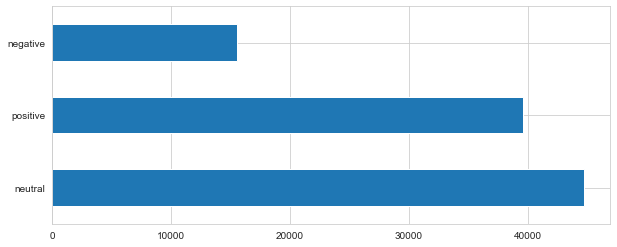

In [39]:
df_final['sentiment'].value_counts().plot(kind='barh', figsize=(10, 4))

In [40]:
df_final['sentiment'].value_counts()

neutral     44719
positive    39632
negative    15519
Name: sentiment, dtype: int64

In [46]:
df_final.sort_values(by='positive', ascending=False).head(10)

,ID,Username,Name,Datetime,Tweet_Id,Text,Tweet_Retweet_count,Tweet_Favorite_count,Tweet_language,Source,Location,Company_url,User_followers_count,User_friends_count,negative,neutral,positive,sentiment
26295,122438,AshleyFriedlein,Ashley Friedlein,2019-11-13 14:18:09,1194620470357905408,Excited to share my #career journey @St Albans School and help students think about career choices @Founders4School https://t.co/ldo5CE3Mk8,0,3,en,Twitter Web Client,"London, UK",https://t.co/C1nyAwzR9A,8519,777,0.001509,0.004804,0.993687,positive
1675,5809,AnneBoden,Anne Boden,2019-11-28 07:04:06,1199947056846127104,"It was wonderful to meet Dame Sian @DameSianP - last night. Thank you Sian for chatting and being so enthusiastic about your work, my work and #bafta #wales https://t.co/AeO7fg7ceA",2,16,en,Twitter for iPhone,London,https://t.co/m1m2DvBaPr,26921,4215,0.001249,0.005089,0.993661,positive
76416,368143,ViviFriedgut,Viv ☕️,2020-11-12 18:28:17,1326954990087393280,"@jencarolan While I'm a fan of candor, honesty and transparency in business (and life TBH) the 3 people who have suggested the radical candor method to me have always used it as an excuse to act like £$%&amp;holes ?",0,3,en,Twitter Web App,"UK, Australia, NZ ?",https://t.co/qtsLuAnnfN,1834,1616,0.001511,0.004846,0.993642,positive
18362,74914,Nrgarner,Neil Garner,2019-10-10 20:52:34,1182398539315458048,RT @thyngs: We got the Norwich Mayor involved in all thyngs cashless for #NorwichStreetAid @NorwichBIDUK ☺️ Making donations through #thyng…,7,0,en,Twitter for iPhone,"Norwich, London and UK",https://t.co/yhTVmOtaAF,1093,963,0.001851,0.004558,0.993591,positive
1792,5928,AnneBoden,Anne Boden,2019-11-02 07:24:33,1190530117690429440,RT @Dr_Black: So excited and honoured to be hosting the first ever @DameStephanie_ lecture @comp_sci_durham @durham_uni this evening ❤️????…,17,0,en,Twitter for iPhone,London,https://t.co/m1m2DvBaPr,26921,4215,0.001031,0.005386,0.993583,positive
52891,233266,Gateley,Ben Branson-Gateley,2020-08-26 17:33:36,1298674974086123520,RT @jenistyping: We're giving away free advice for writing better job descriptions in the below thread ??,3,0,en,Twitter for iPad,London,https://t.co/xxxhsJ3Ylh,1453,1377,0.001300,0.005126,0.993574,positive
31882,139157,dctanner,Damien C. Tanner,2019-04-29 15:45:08,1122889563649859584,@pocketsupport Hi! There are 3 things I'd love:\n1) auto tagging based on content. I save any webpage I just want to easily find again. These pages get muddled up with article I want to read.,0,0,en,Twitter for Android,"London, England",https://t.co/NOv52lD5gh,2442,192,0.001167,0.005261,0.993573,positive
79161,387680,SusanneMitschke,Susanne Mitschke,2020-04-21 18:26:51,1252665116270530560,"RT @citrus_labs: To help find a cure as quick as possible, we have volunteered our services to clinical trials researching COVID-19:\nhttps:…",5,0,en,Twitter for iPhone,"Los Angeles, CA",https://t.co/YlTPjHPDqg,1199,883,0.001202,0.005229,0.993569,positive
12767,27691,ChrisSheldrick,Chris Sheldrick,2019-03-16 11:10:15,1106875318671998976,"RT @what3words: Today we revealed at #MWC our exciting new partnership with @Ford! By supporting what3words voice navigation, it enables mi…",36,0,en,Twitter for Android,///filled.count.soap,https://t.co/v10Q7bMjSp,3289,1039,0.001267,0.005165,0.993568,positive
66621,310139,melindanicci,Melinda Nicci ????,2020-03-22 11:48:29,1241693225456406528,Happy #mothersday to all UK #mums. We’ve slashed our prices to bring you premium content to help you stay strong and healthy in these difficult times. Only available on our website. We’ve also unlocked more workouts for our free users. #stayhealthy #fit https://t.co/45owdpW3pf https://t.co/aREwvsIVow,0,1,en,Twitter for iPhone,London,https://t.co/UtEM57SjfV,1281,1224,0.001298,0.005178,0.993524,positive
